In [2]:
include("read_nu_dist_sphere.jl")
include("read_eff_area.jl")
include("read_energy_res.jl")
include("functions_utils.jl")

# Packages

using DelimitedFiles
using StatsBase
using Interpolations
using Plots
using LaTeXStrings
using FFTW
using Distributions
using Profile
using PyCall
using SpecialFunctions
using Optim
using StaticArrays
using Healpix
using BenchmarkTools
using CurveFit
using ApproxFun

# Importing the necessary python libraries
@pyimport matplotlib.pyplot as plt
@pyimport numpy as np
@pyimport healpy as hp

In [3]:
# Loading the models and necessary data

model = "galnu_GALcase2"

# Getting spatial data
rs, ls, bs, rws, us, logCRes = read_models(model)
oneweights = Weights(ones(length(rws)))

# Getting the (previously unneeded) energy gc_data
minu, maxu = minimum(us), maximum(us)
logνebins = range(minu, maxu, 100)


# Cut all neutrinos outside our effective area energy bounds

function energy_cut(rs, ls, bs, rws, us, oneweights)
    concatmat = hcat(rs, ls, bs, rws, us, oneweights)
    filtered_matrix_rows = [row for row in eachrow(concatmat) if log10(emin) <= row[5] <= log10(emax)]
    filtered_mat = hcat(filtered_matrix_rows...)
    fmat = transpose(filtered_mat)
end

cut = energy_cut(rs, ls, bs, rws, us, oneweights)
rs, ls, bs, rws, us, oneweights = cut[:,1], cut[:,2], cut[:,3], cut[:,4], cut[:,5], cut[:,6]
;

In [4]:
# Functions that smear the Monte Carlo

function angsmearMC(ls, bs, us)
    numν = length(ls)
    ls_sm = zeros(numν)
    bs_sm = zeros(numν)

    for i in 1:numν
        dist = MvNormal([ls[i], bs[i]], 0.122)
        l_sm, b_sm = rand(dist, 1)

        # Changing the coordinates to fit in the \ell, b bounds
        if b_sm > π/2
            b_sm = π - b_sm
            if l_sm > 0
                l_sm -= π
            else
                l_sm += π
            end
        end
        if b_sm < -π/2
            b_sm = -π - b_sm
            if l_sm > 0
                l_sm -= π
            else
                l_sm += π
            end
        end

        if l_sm > π
            l_sm -= 2π
        end
        if l_sm < -π
            l_sm += 2π
        end
            
        ls_sm[i] = l_sm
        bs_sm[i] = b_sm
    end
    return (ls_sm, bs_sm)
end

angsmearMC (generic function with 1 method)

In [13]:
power_law_flux(E, γ, ϕ₀=1, E0=1) = ϕ₀ * (E / E0)^(-γ)

new_us = power_law_flux.(10 .^ us, 2.4-1.0)

aws = effarea.(10 .^ new_us) * 10000
;

In [17]:
10 .^ (us[70])

1.2334

In [15]:
new_us[70]

0.7455117251462208

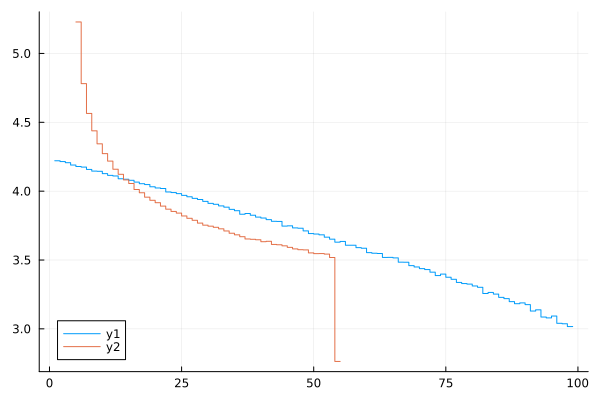

In [14]:
binned_us = Distributions.fit(Histogram, us, range(log10(emin), log10(emax), 100))
binned_new_us = Distributions.fit(Histogram, new_us, range(log10(emin), log10(emax), 100))
plot([log10.(binned_us.weights) log10.(binned_new_us.weights)], seriestype=:step)

In [1]:
dm2 = 0
dm2 = ones(length(rs)) .* dm2
oscws = oscprob.(10 .^ new_us, dm2, rs);

LoadError: UndefVarError: `rs` not defined

In [177]:
dm2_alt = ones(length(rs)) .* 10^(-13.5)
oscws_alt = oscprob.(10 .^ new_us, dm2_alt, rs);

In [178]:
ws = Weights( (rws ./ (rs .^2) .* aws .* oscws) )
ws_alt = Weights( (rws ./ (rs .^2) .* aws .* oscws_alt) );

In [179]:
function weighthist_es(rs, ls, bs, us, weights; removed_bins=1, rbinsize=0.1, θbinsize=π/25, minloge=log10(emin), maxloge=log10(emax), elength=201)

    # We take square angular bins
    rbins, lbins, bbins, logebins = 0:rbinsize:20, -π:θbinsize:π, -π/2:θbinsize:π/2, range(minloge, maxloge, length=elength)

    # Histogramming the simulation by our radial and angular bins
    nuhist = StatsBase.fit(Histogram, (rs, ls, bs, us), weights, (rbins, lbins, bbins, logebins), closed=:left)
    nuweights = nuhist.weights

    # removing bins to see what happens... (we expect very few neutrinos within 0.1 kpc from Earth, so it's set to 1)
    if removed_bins > 0
        nuweights[1:removed_bins, :, :, :] .= 0
    end

    return nuweights

end

weighthist_es (generic function with 1 method)

In [180]:
binning = weighthist_es(rs, ls, bs, new_us, ws, elength=26)
binning_alt = weighthist_es(rs, ls, bs, new_us, ws_alt, elength=26)
;

In [181]:
lbbin = vec(sum(binning[:, 25, 13, :], dims=1))
lbbin_alt = vec(sum(binning_alt[:, 25, 13, :], dims=1))
;

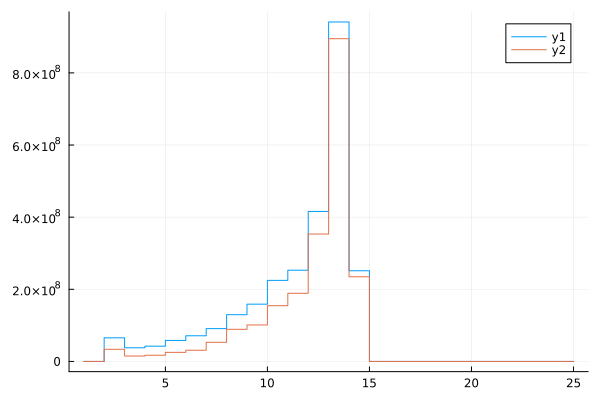

In [182]:
plot([lbbin lbbin_alt], seriestype=:step)

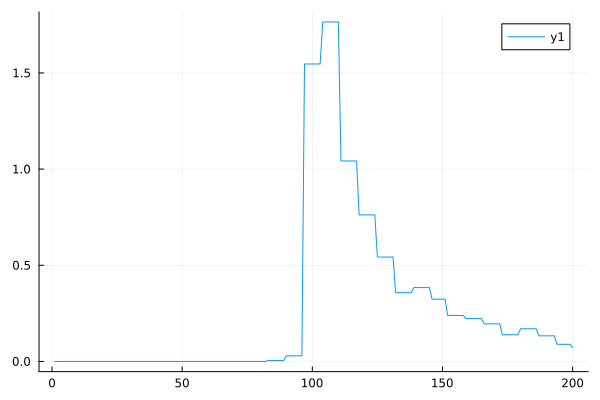

In [13]:
plot(erestrue[100,:])

In [19]:
eres_non_extrap = Interpolations.interpolate((loges, loges), erestrue, Gridded(Linear())) # in m^2
eres = extrapolate(eres_non_extrap, 0.0)

200×200 extrapolate(interpolate((-0.3010299956639812:0.019613517522572583:3.6020599913279625,-0.3010299956639812:0.019613517522572583:3.6020599913279625), ::Matrix{Float64}, Gridded(Linear())), 0.0) with element type Float64:
 4.59509  4.59509  4.59509  4.59509  …  0.00454625  0.00454625  0.00913249
 6.63681  6.63681  6.63681  6.63681     0.00454625  0.00454625  0.00913249
 6.63681  6.63681  6.63681  6.63681     0.00454625  0.00454625  0.00913249
 6.63681  6.63681  6.63681  6.63681     0.00454625  0.00454625  0.00913249
 6.63681  6.63681  6.63681  6.63681     0.00454625  0.00454625  0.00913249
 6.63681  6.63681  6.63681  6.63681  …  0.00454625  0.00454625  0.00913249
 6.63681  6.63681  6.63681  6.63681     0.00454625  0.00454625  0.00913249
 1.02122  1.02122  1.02122  1.02122     0.0         0.0         1.79457
 1.02122  1.02122  1.02122  1.02122     0.0         0.0         1.79457
 1.02122  1.02122  1.02122  1.02122     0.0         0.0         1.79457
 1.02122  1.02122  1.02122  1.021

In [101]:
d = Distributions.fit_mle(Normal, erestrue[:, 10])

f(x) = pdf(d, x)

f (generic function with 1 method)

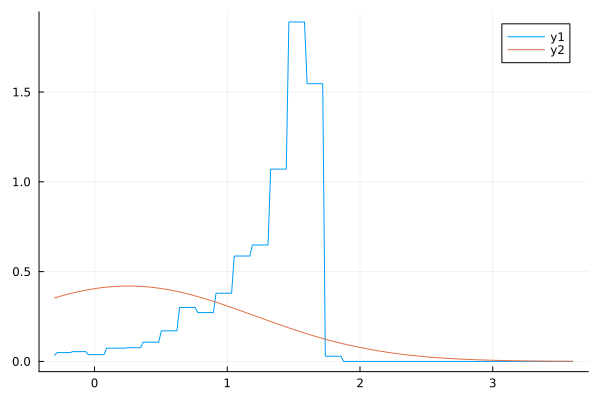

In [102]:
plot(loges,
    [erestrue[:, 100] f.(loges)]
)

In [65]:
StatsBase.sample(ones(length(rs)), distweights)

1.0